In [1]:
from tqdm import tqdm

from lib import mut, plot

from lib.dataloader import load_data
from lib.task import make_tasks

from lib.solver.anneal_solver import AnnealSolver
from lib.temperature import exponential

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = load_data('../all')

big_data = sorted([df for df in data.values() if len(df['trace']) >= 200], key=lambda df: len(df['trace']))
big_tasks = make_tasks(big_data)
top10 = big_tasks[-10:]

100%|██████████| 52967/52967 [02:09<00:00, 409.05it/s]


In [4]:
mutation = mut.concat(
    mut.conditional(
        mut.TryMakeBusyAllCandidateWithGreedyRoute,
        epoch_predicat=lambda epoch: epoch == 0
    ),
    mut.conditional(
        mut.concat(
            mut.MakeRoomForRandomCandidate,
            mut.TryMakeBusyAllCandidateWithGreedyRoute,
            mut.FlippityFlop(limit=50),
        ),
        epoch_predicat=lambda epoch: epoch != 0 and epoch % 100 == 0
    ),
    mut.randomize(
        mut.Flip(),
        mut.TryMakeBusyAnyCandidateWithGreedyRoute,
        mut.TryMakeBusyRandomCandidateWithRandomRoute,
        mut.TryMakeBusyRandomCandidateWithGreedyRoute,
        mut.TryMakeIdleRandomCandidate,
        k=3,
    ),
)

solver = AnnealSolver(
    mutation=mutation,
    epoches=10_000,
    temp=exponential(10000, 1.0005),
    beamsearch_size=2,
)

In [5]:
solver.solve_all(*top10, retries=10, tqdm=tqdm)

100%|██████████| 100/100 [15:31<00:00,  9.31s/it]


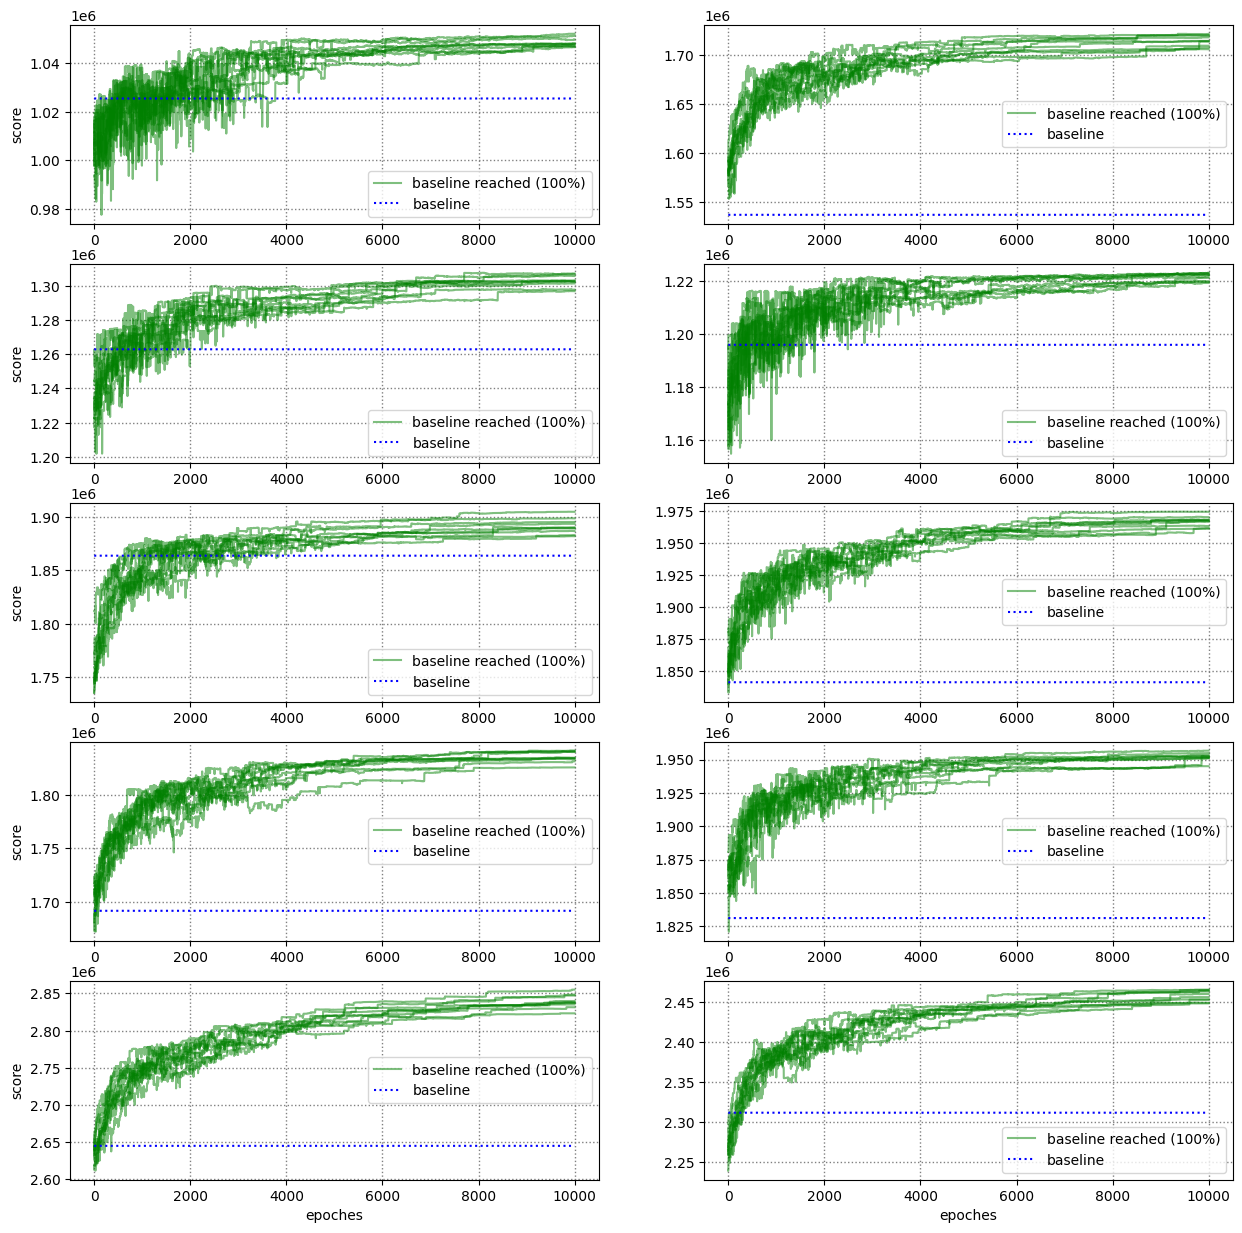

In [6]:
plot.solve_history(*top10, exclude_init=True)

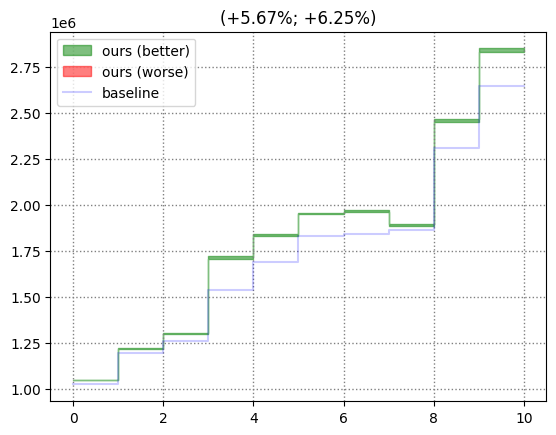

In [7]:
plot.total_diff_interval(*top10, confidence_interval=(0.1, 0.9))

In [8]:
solver.solve_all(*big_tasks, tqdm=tqdm)

100%|██████████| 997/997 [1:08:52<00:00,  4.15s/it]


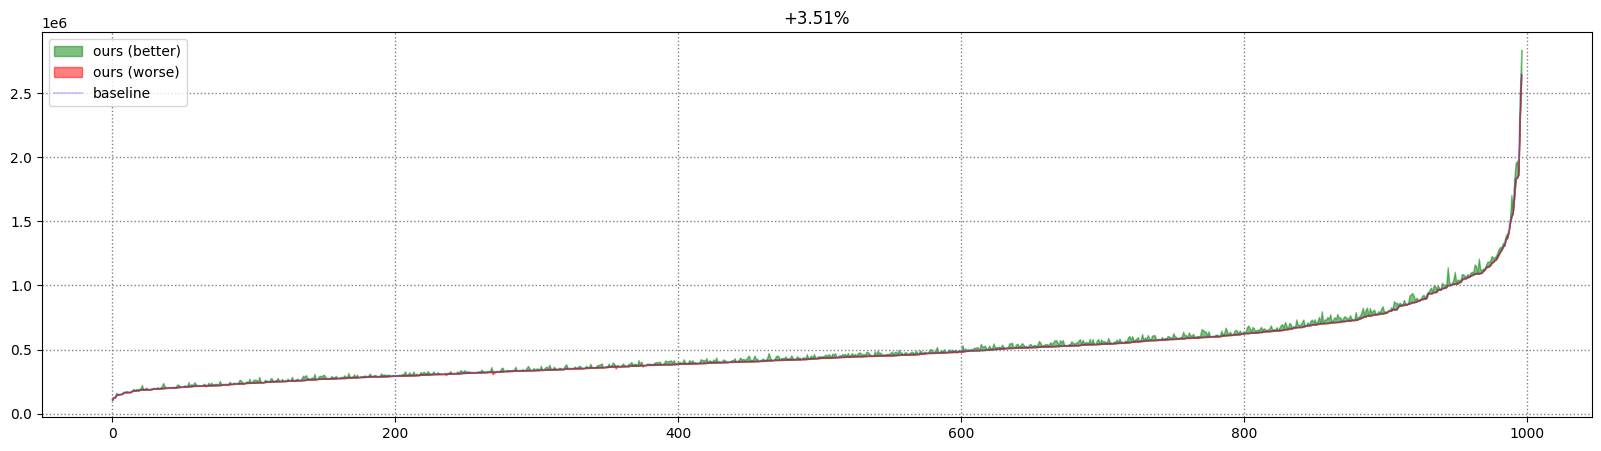

In [9]:
plot.total_diff(*big_tasks, last_n=1, figsize=(20, 5))

In [10]:
%prun -s cumulative solver.solve(big_tasks[0])

         12537596 function calls (11221920 primitive calls) in 5.242 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    5.247    5.247 {built-in method builtins.exec}
        1    0.007    0.007    5.247    5.247 <string>:1(<module>)
        1    0.006    0.006    5.240    5.240 anneal_solver.py:24(solve)
        1    0.036    0.036    5.226    5.226 anneal.py:86(anneal_beamsearch)
    13845    0.025    0.000    4.911    0.000 anneal.py:100(<listcomp>)
    27690    0.048    0.000    4.886    0.000 anneal.py:30(iterate_anneal)
    27690    0.010    0.000    4.671    0.000 anneal.py:100(<lambda>)
    27690    0.024    0.000    4.661    0.000 anneal_solver.py:28(mutate)
55654/27690    0.039    0.000    4.548    0.000 combine.py:41(impl)
55654/27690    0.068    0.000    4.527    0.000 combine.py:42(<listcomp>)
    27690    0.040    0.000    4.371    0.000 combine.py:57(impl)
    16735    0.098    0

In [11]:
%prun -s cumulative solver.solve(big_tasks[-1])

         97673897 function calls (80085074 primitive calls) in 30.248 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   30.253   30.253 {built-in method builtins.exec}
        1    0.007    0.007   30.253   30.253 <string>:1(<module>)
        1    0.006    0.006   30.247   30.247 anneal_solver.py:24(solve)
        1    0.043    0.043   30.233   30.233 anneal.py:86(anneal_beamsearch)
    14563    0.027    0.000   29.861    0.002 anneal.py:100(<listcomp>)
    29126    0.056    0.000   29.833    0.001 anneal.py:30(iterate_anneal)
    29126    0.011    0.000   29.585    0.001 anneal.py:100(<lambda>)
    29126    0.028    0.000   29.574    0.001 anneal_solver.py:28(mutate)
58548/29126    0.042    0.000   29.441    0.001 combine.py:41(impl)
58548/29126    0.079    0.000   29.418    0.001 combine.py:42(<listcomp>)
    29126    0.050    0.000   28.665    0.001 combine.py:57(impl)
    17233    1.069    